# PostgreSQL B-tree Index Performance Analysis
## Disk-Resident Dataset (16M rows) - 3 Round Results

This notebook analyzes the performance tradeoffs between no indexing vs single-column B-tree indexing across different OLTP read/write workloads.

**Experimental Setup:**
- Dataset: 16M rows (~2× RAM, disk-resident)
- PostgreSQL 15 with 4 CPUs, 8GB RAM
- Indexing: No index vs B-tree on `indexed_col`
- Read/Write Ratios: 90/10, 50/50, 10/90
- Concurrency Levels: 1, 8, 16, 32 clients
- 3 rounds for statistical confidence

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure plot defaults
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Create directory for plot exports
PLOTS_DIR = Path('analysis_outputs/plots')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_RESOLUTION = 96 # Shift this value when generating reports
print(f"Plot exports will be saved to: {PLOTS_DIR.absolute()}")

Plot exports will be saved to: /home/lemasc/projects/nao-docker/db_readwrite/analysis_outputs/plots


## 1. Data Loading and Preparation

In [24]:
def load_all_results(base_path='results/disk-resident'):
    """
    Load all JSON results from 3 rounds.
    Returns a structured DataFrame with configuration and metrics.
    """
    all_data = []
    
    for round_num in [1, 2, 3]:
        round_path = Path(base_path) / str(round_num) / 'results'
        json_files = list(round_path.glob('*.json'))
        
        # Filter out copy files
        json_files = [f for f in json_files if 'copy' not in f.name]
        
        for json_file in json_files:
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            # Extract configuration
            config = data['config']
            read_ratio, write_ratio = config['read_write_ratio']
            
            # Create base record
            base_record = {
                'round': round_num,
                'indexed': config['indexed'],
                'index_label': 'Indexed' if config['indexed'] else 'No Index',
                'read_ratio': read_ratio,
                'write_ratio': write_ratio,
                'ratio_label': f"{read_ratio}/{write_ratio}",
                'concurrency': config['concurrency'],
                'duration_seconds': data['duration_seconds'],
                'total_operations': data['total_operations'],
                'total_ops_per_sec': data['operations_per_second']
            }
            
            # Extract per-operation metrics
            for op_type, metrics in data['summary'].items():
                record = base_record.copy()
                record.update({
                    'operation': op_type,
                    'count': metrics['count'],
                    'success': metrics['success'],
                    'error': metrics['error'],
                    'min_latency_ms': metrics['min_latency_ms'],
                    'max_latency_ms': metrics['max_latency_ms'],
                    'mean_latency_ms': metrics['mean_latency_ms'],
                    'p50_latency_ms': metrics['p50_latency_ms'],
                    'p95_latency_ms': metrics['p95_latency_ms'],
                    'p99_latency_ms': metrics['p99_latency_ms'],
                    'ops_per_sec': metrics['ops_per_sec'],
                    'timeout_statement': metrics['errors_by_type']['timeout_statement'],
                    'timeout_lock': metrics['errors_by_type']['timeout_lock'],
                    'deadlock': metrics['errors_by_type']['deadlock'],
                    'error_other': metrics['errors_by_type']['other']
                })
                all_data.append(record)
    
    df = pd.DataFrame(all_data)
    
    # Add operation categories
    df['op_category'] = df['operation'].apply(
        lambda x: 'read' if x in ['point_lookup', 'range_scan', 'range_order'] else 'write'
    )
    
    return df

# Load all data
df = load_all_results()

print(f"Loaded {len(df)} records")
print(f"Rounds: {sorted(df['round'].unique())}")
print(f"Configurations: {len(df.groupby(['indexed', 'ratio_label', 'concurrency', 'operation']))}")
print(f"Operations: {sorted(df['operation'].unique())}")

df.head()

Loaded 354 records
Rounds: [np.int64(1), np.int64(2), np.int64(3)]
Configurations: 119
Operations: ['insert', 'point_lookup', 'range_order', 'range_scan', 'update']


,round,indexed,index_label,read_ratio,write_ratio,ratio_label,concurrency,duration_seconds,total_operations,total_ops_per_sec,...,mean_latency_ms,p50_latency_ms,p95_latency_ms,p99_latency_ms,ops_per_sec,timeout_statement,timeout_lock,deadlock,error_other,op_category
0,1,True,Indexed,50,50,50/50,32,300.207747,124374,414.293107,...,2.530827,1.210762,7.776112,11.119863,103.844755,0,0,0,0,read
1,1,True,Indexed,50,50,50/50,32,300.207747,124374,414.293107,...,31.839986,32.273880,44.330894,50.308167,103.544963,0,0,0,0,write
2,1,True,Indexed,50,50,50/50,32,300.207747,124374,414.293107,...,29.613781,29.627316,42.627271,47.684549,103.148571,0,0,0,0,write
3,1,True,Indexed,50,50,50/50,32,300.207747,124374,414.293107,...,244.687085,254.160848,289.716397,302.751641,41.511254,0,0,0,0,read
4,1,True,Indexed,50,50,50/50,32,300.207747,124374,414.293107,...,244.224433,253.985672,289.434697,303.260765,62.243564,0,0,0,0,read


In [25]:
# Compute aggregated statistics across rounds
def compute_statistics(df):
    """
    Aggregate metrics across 3 rounds with mean and 95% confidence intervals.
    """
    group_cols = ['indexed', 'index_label', 'read_ratio', 'write_ratio', 'ratio_label',
                  'concurrency', 'operation', 'op_category']

    # Define aggregation functions separately for compatibility
    def calc_ci_95(series):
        """Calculate 95% confidence interval using t-distribution"""
        n = len(series)
        if n > 1:
            std = series.std()
            return stats.t.ppf(0.975, n-1) * std / np.sqrt(n)
        return 0

    # Aggregate with standard functions
    agg_df = df.groupby(group_cols).agg({
        'p95_latency_ms': ['mean', 'std', 'min', 'max', calc_ci_95],
        'p50_latency_ms': ['mean', 'std', 'min', 'max', calc_ci_95],
        'mean_latency_ms': ['mean', 'std', 'min', 'max', calc_ci_95],
        'ops_per_sec': ['mean', 'std', 'min', 'max', calc_ci_95],
        'total_ops_per_sec': ['mean', 'std', 'min', 'max', calc_ci_95],
        'count': ['mean', 'std', 'min', 'max', calc_ci_95],
        'error': 'sum',
        'timeout_statement': 'sum',
        'timeout_lock': 'sum',
        'deadlock': 'sum'
    }).reset_index()

    # Flatten multi-level columns with proper naming
    new_columns = []
    for col in agg_df.columns:
        if isinstance(col, tuple):
            if col[1] == 'calc_ci_95':
                new_columns.append(f"{col[0]}_ci_95")
            elif col[1] in ['mean', 'std', 'min', 'max']:
                new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append('_'.join(str(c) for c in col).strip('_'))
        else:
            new_columns.append(col)

    agg_df.columns = new_columns

    return agg_df

stats_df = compute_statistics(df)
print(f"\nAggregated statistics: {len(stats_df)} configurations")
stats_df.head(10)


Aggregated statistics: 119 configurations


,indexed,index_label,read_ratio,write_ratio,ratio_label,concurrency,operation,op_category,p95_latency_ms_mean,p95_latency_ms_std,...,total_ops_per_sec_ci_95,count_mean,count_std,count_min,count_max,count_ci_95,error_sum,timeout_statement_sum,timeout_lock_sum,deadlock_sum
0,False,No Index,10,90,10/90,1,insert,write,0.872003,0.096345,...,0.390789,55.666667,22.007574,34,78,54.669846,0,0,0,0
1,False,No Index,10,90,10/90,1,point_lookup,read,44581.265323,25235.498175,...,0.390789,6.666667,2.081666,5,9,5.171145,16,16,0,0
2,False,No Index,10,90,10/90,1,range_order,read,30011.670740,1.383609,...,1.121072,2.500000,2.121320,1,4,19.059307,5,5,0,0
3,False,No Index,10,90,10/90,1,range_scan,read,4.159997,0.527811,...,0.390789,4.000000,2.000000,2,6,4.968275,0,0,0,0
4,False,No Index,10,90,10/90,1,update,write,1.536843,0.165295,...,0.390789,55.000000,19.000000,39,76,47.198617,0,0,0,0
5,False,No Index,10,90,10/90,8,insert,write,1.449300,0.271680,...,0.107348,474.333333,46.306947,440,527,115.032833,0,0,0,0
6,False,No Index,10,90,10/90,8,point_lookup,read,30013.056478,2.102351,...,0.107348,54.666667,3.214550,51,57,7.985386,163,163,0,0
7,False,No Index,10,90,10/90,8,range_order,read,44827.285562,25663.839896,...,0.107348,23.666667,0.577350,23,24,1.434218,68,68,0,0
8,False,No Index,10,90,10/90,8,range_scan,read,14.500536,2.035468,...,0.107348,33.666667,10.408330,22,42,25.855725,0,0,0,0
9,False,No Index,10,90,10/90,8,update,write,4.226290,0.349947,...,0.107348,495.666667,22.368132,476,520,55.565520,0,0,0,0


## 2. Data Quality Check

In [26]:
# Check for errors and timeouts
error_summary = df.groupby(['indexed', 'ratio_label', 'concurrency', 'operation']).agg({
    'error': 'sum',
    'timeout_statement': 'sum',
    'timeout_lock': 'sum',
    'deadlock': 'sum'
}).reset_index()

total_errors = error_summary['error'].sum()
total_timeouts = error_summary['timeout_statement'].sum() + error_summary['timeout_lock'].sum()

print(f"Total errors across all runs: {total_errors}")
print(f"Total timeouts: {total_timeouts}")

if total_errors > 0 or total_timeouts > 0:
    print("\nConfigurations with errors/timeouts:")
    problematic = error_summary[
        (error_summary['error'] > 0) | 
        (error_summary['timeout_statement'] > 0) | 
        (error_summary['timeout_lock'] > 0)
    ]
    display(problematic)
else:
    print("✓ No errors or timeouts detected - clean dataset!")

Total errors across all runs: 3798
Total timeouts: 3798

Configurations with errors/timeouts:


,indexed,ratio_label,concurrency,operation,error,timeout_statement,timeout_lock,deadlock
1,False,10/90,1,point_lookup,16,16,0,0
2,False,10/90,1,range_order,5,5,0,0
6,False,10/90,8,point_lookup,163,163,0,0
7,False,10/90,8,range_order,68,68,0,0
11,False,10/90,16,point_lookup,338,338,0,0
12,False,10/90,16,range_order,142,142,0,0
16,False,10/90,32,point_lookup,675,675,0,0
17,False,10/90,32,range_order,285,285,0,0
21,False,50/50,1,point_lookup,22,22,0,0
22,False,50/50,1,range_order,8,8,0,0


In [27]:
# Check variability across rounds
variability = stats_df[['indexed', 'ratio_label', 'concurrency', 'operation', 
                        'p95_latency_ms_mean', 'p95_latency_ms_std', 'p95_latency_ms_ci_95']].copy()
variability['cv'] = (variability['p95_latency_ms_std'] / variability['p95_latency_ms_mean'] * 100).round(2)
variability = variability.sort_values('cv', ascending=False)

print("\nTop 10 most variable configurations (by coefficient of variation):")
display(variability.head(10))

print(f"\nMedian CV: {variability['cv'].median():.2f}%")
print(f"Mean CV: {variability['cv'].mean():.2f}%")


Top 10 most variable configurations (by coefficient of variation):


,indexed,ratio_label,concurrency,operation,p95_latency_ms_mean,p95_latency_ms_std,p95_latency_ms_ci_95,cv
49,False,90/10,16,insert,5.360385,4.541455,11.281600,84.72
32,False,50/50,16,range_order,44844.397018,25698.676466,63839.051352,57.31
7,False,10/90,8,range_order,44827.285562,25663.839896,63752.512515,57.25
1,False,10/90,1,point_lookup,44581.265323,25235.498175,62688.452693,56.61
43,False,90/10,1,update,4.938565,2.661334,23.911134,53.89
48,False,90/10,8,update,5.497527,2.874491,7.140631,52.29
54,False,90/10,32,insert,11.471712,5.471152,13.591094,47.69
31,False,50/50,16,point_lookup,59599.675720,25623.922277,63653.351650,42.99
37,False,50/50,32,range_order,59625.529257,25531.373540,63423.447844,42.82
35,False,50/50,32,insert,8.237164,3.120331,7.751333,37.88



Median CV: 1.77%
Mean CV: 9.81%


## 3. P95 Latency Analysis

Primary decision-driving metric: **P95 latency** per operation type.

Saved: analysis_outputs/plots/01_p95_latency_all_operations.png


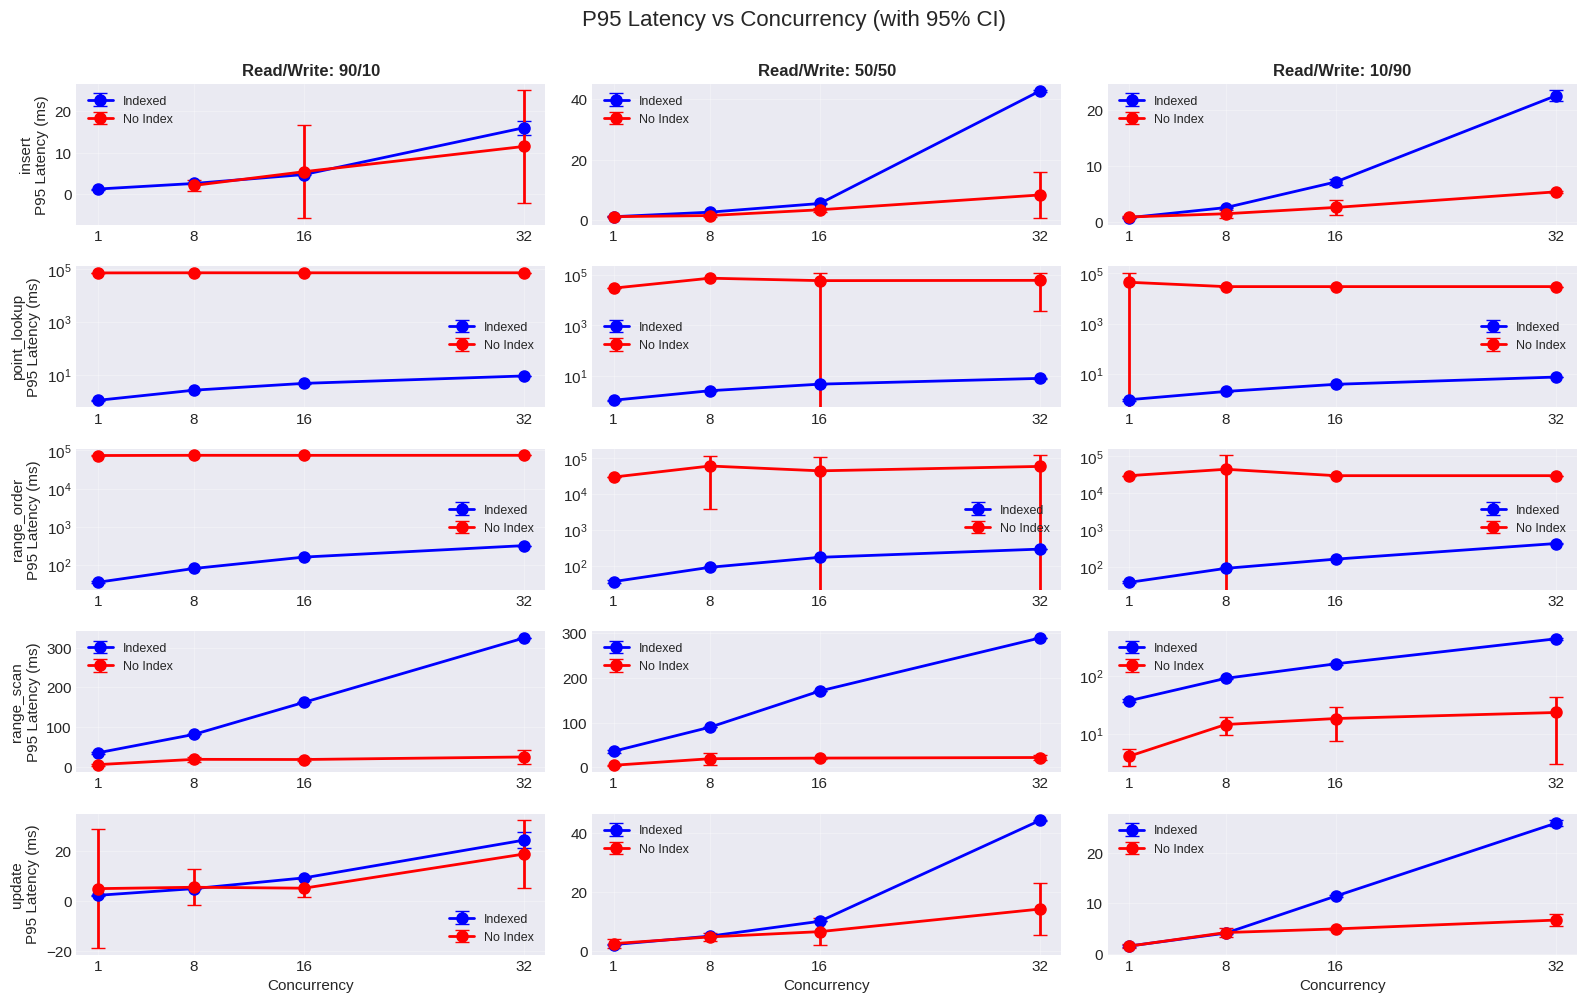

In [28]:
def plot_p95_latency_by_ratio(stats_df, operation_filter=None, figsize=(16, 10)):
    """
    Plot P95 latency vs concurrency for each read/write ratio.
    Separate plots for each operation type.
    """
    df_plot = stats_df.copy()
    
    if operation_filter:
        df_plot = df_plot[df_plot['operation'].isin(operation_filter)]
    
    operations = sorted(df_plot['operation'].unique())
    ratios = sorted(df_plot['ratio_label'].unique(), key=lambda x: int(x.split('/')[0]), reverse=True)
    
    fig, axes = plt.subplots(len(operations), len(ratios), figsize=figsize, squeeze=False)
    fig.suptitle('P95 Latency vs Concurrency (with 95% CI)', fontsize=16, y=1.0)
    
    for op_idx, operation in enumerate(operations):
        for ratio_idx, ratio in enumerate(ratios):
            ax = axes[op_idx, ratio_idx]
            
            data = df_plot[(df_plot['operation'] == operation) & (df_plot['ratio_label'] == ratio)]
            
            for indexed in [True, False]:
                subset = data[data['indexed'] == indexed].sort_values('concurrency')
                
                if len(subset) > 0:
                    label = 'Indexed' if indexed else 'No Index'
                    color = 'blue' if indexed else 'red'
                    
                    ax.errorbar(
                        subset['concurrency'], 
                        subset['p95_latency_ms_mean'],
                        yerr=subset['p95_latency_ms_ci_95'],
                        marker='o', 
                        label=label,
                        color=color,
                        capsize=5,
                        linewidth=2,
                        markersize=8
                    )
            
            # Formatting
            if op_idx == 0:
                ax.set_title(f'Read/Write: {ratio}', fontsize=12, fontweight='bold')
            if ratio_idx == 0:
                ax.set_ylabel(f'{operation}\nP95 Latency (ms)', fontsize=11)
            if op_idx == len(operations) - 1:
                ax.set_xlabel('Concurrency', fontsize=11)
            
            ax.set_xticks([1, 8, 16, 32])
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best', fontsize=9)
            
            # Use log scale for y-axis if range is large
            if data['p95_latency_ms_mean'].max() / data['p95_latency_ms_mean'].min() > 100:
                ax.set_yscale('log')
    
    plt.tight_layout()
    return fig

# Plot all operations
fig = plot_p95_latency_by_ratio(stats_df)
fig.savefig(PLOTS_DIR / '01_p95_latency_all_operations.png', dpi=PLOTS_RESOLUTION, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR / '01_p95_latency_all_operations.png'}")
plt.show()

Saved: analysis_outputs/plots/02_p95_latency_read_operations.png


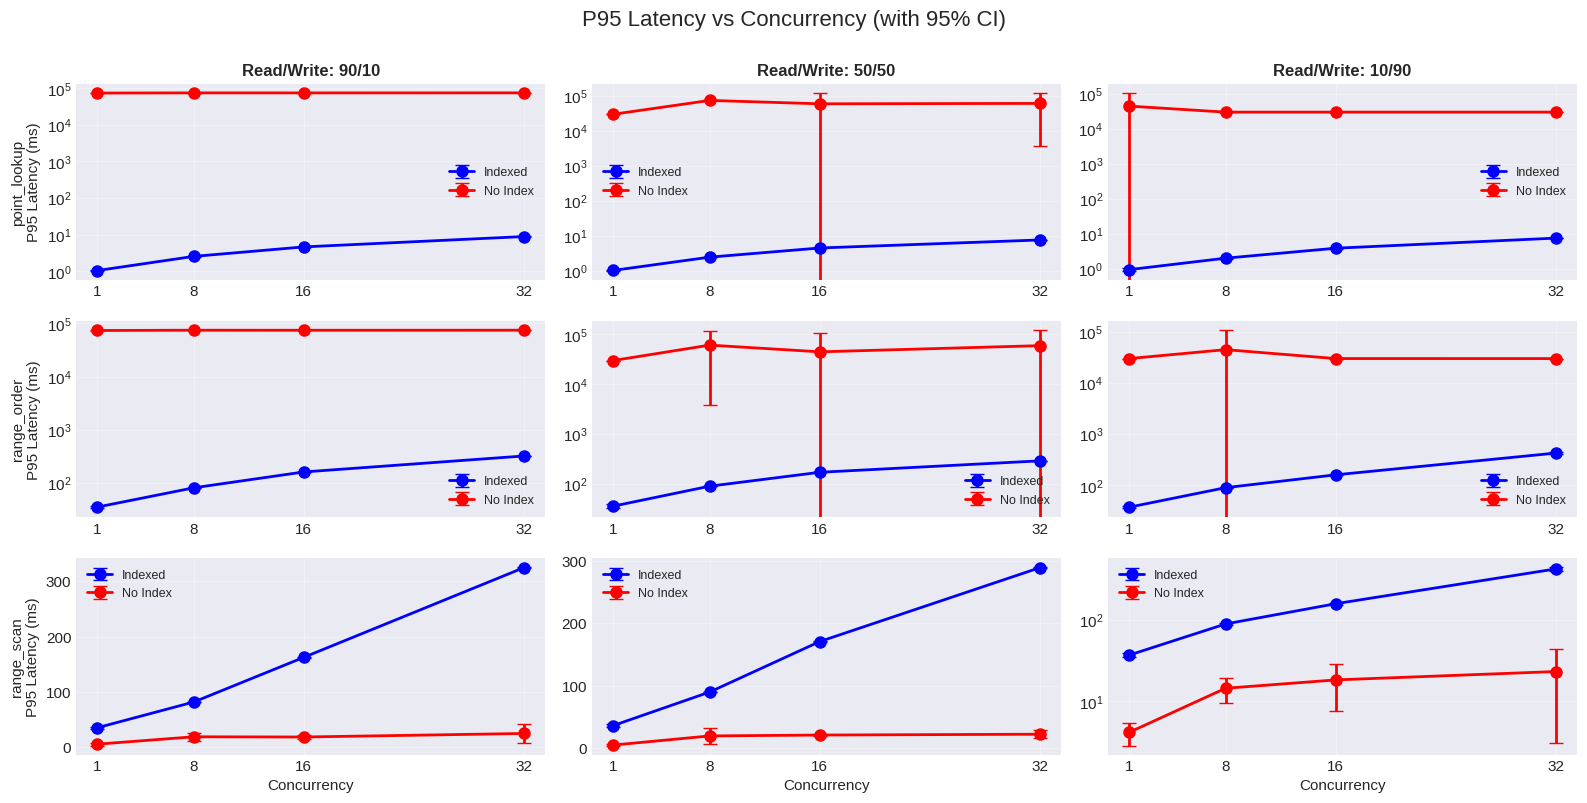

In [29]:
# Focused view: Read operations only
fig = plot_p95_latency_by_ratio(
    stats_df, 
    operation_filter=['point_lookup', 'range_scan', 'range_order'],
    figsize=(16, 8)
)
fig.savefig(PLOTS_DIR / '02_p95_latency_read_operations.png', dpi=PLOTS_RESOLUTION, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR / '02_p95_latency_read_operations.png'}")
plt.show()

Saved: analysis_outputs/plots/03_p95_latency_write_operations.png


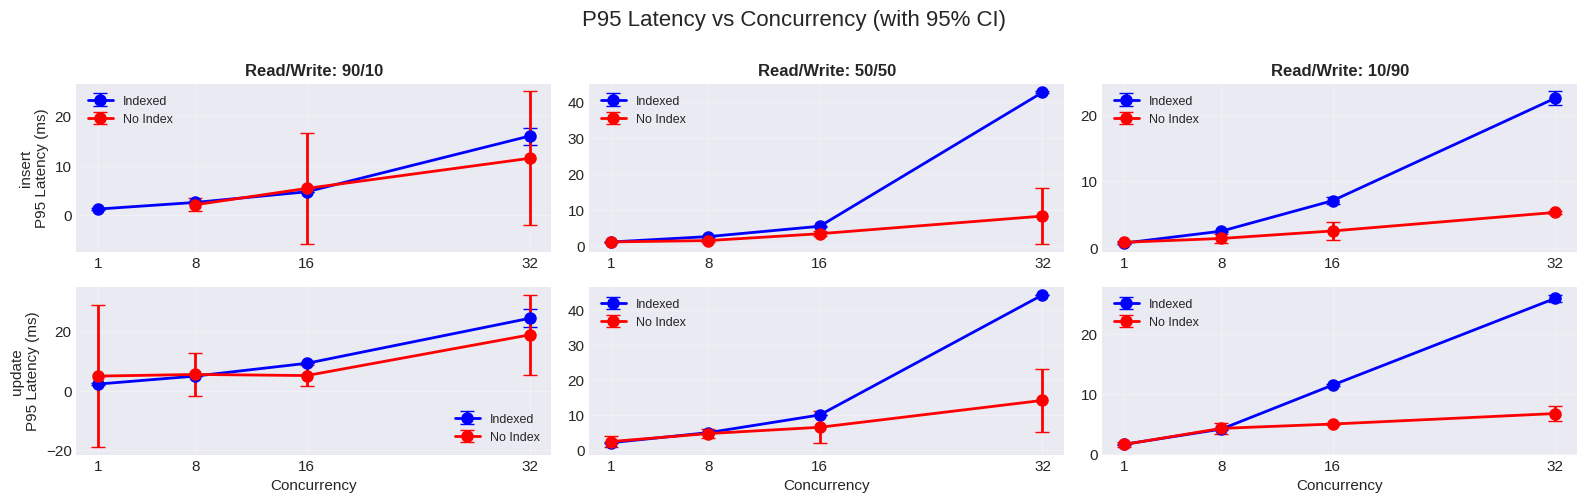

In [30]:
# Focused view: Write operations only
fig = plot_p95_latency_by_ratio(
    stats_df, 
    operation_filter=['insert', 'update'],
    figsize=(16, 5)
)
fig.savefig(PLOTS_DIR / '03_p95_latency_write_operations.png', dpi=PLOTS_RESOLUTION, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR / '03_p95_latency_write_operations.png'}")
plt.show()

## 4. Throughput Analysis

Saved: analysis_outputs/plots/04_total_throughput.png


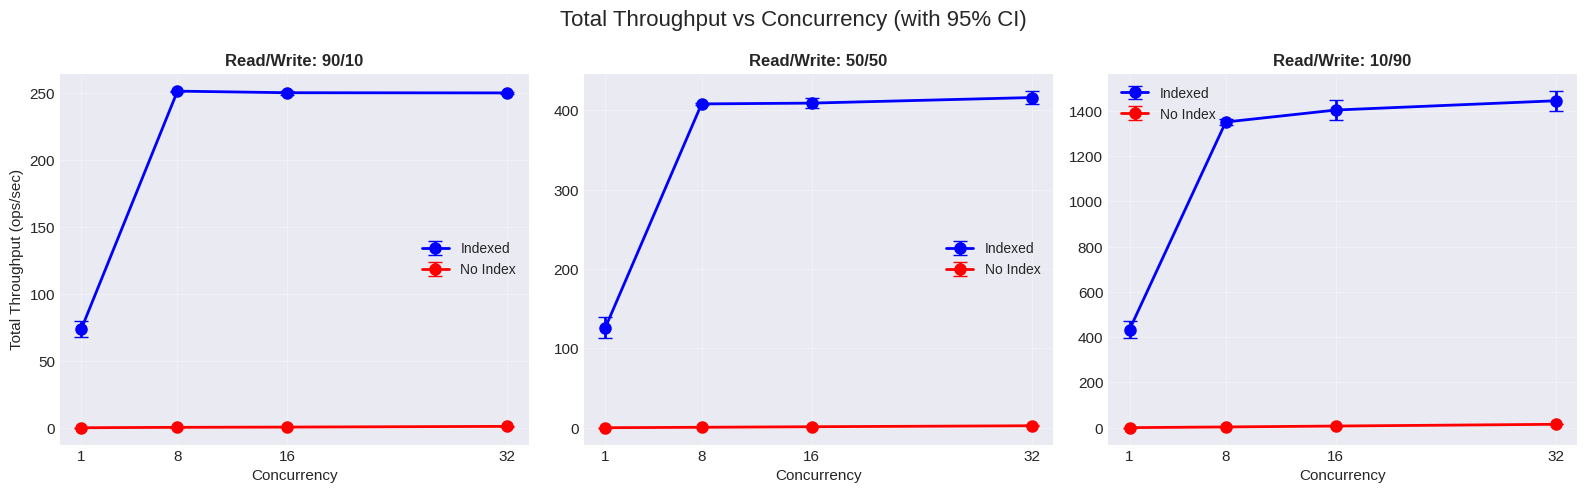

In [31]:
def plot_throughput_by_ratio(stats_df, figsize=(16, 5)):
    """
    Plot total throughput (ops/sec) vs concurrency for each ratio.
    """
    # Get total throughput (aggregate across operations for same config)
    throughput_df = stats_df.groupby(['indexed', 'index_label', 'ratio_label', 'concurrency']).agg({
        'total_ops_per_sec_mean': 'first',  # Already aggregated
        'total_ops_per_sec_ci_95': 'first'
    }).reset_index()
    
    ratios = sorted(throughput_df['ratio_label'].unique(), key=lambda x: int(x.split('/')[0]), reverse=True)
    
    fig, axes = plt.subplots(1, len(ratios), figsize=figsize, squeeze=False)
    fig.suptitle('Total Throughput vs Concurrency (with 95% CI)', fontsize=16)
    
    for ratio_idx, ratio in enumerate(ratios):
        ax = axes[0, ratio_idx]
        data = throughput_df[throughput_df['ratio_label'] == ratio]
        
        for indexed in [True, False]:
            subset = data[data['indexed'] == indexed].sort_values('concurrency')
            
            if len(subset) > 0:
                label = 'Indexed' if indexed else 'No Index'
                color = 'blue' if indexed else 'red'
                
                ax.errorbar(
                    subset['concurrency'], 
                    subset['total_ops_per_sec_mean'],
                    yerr=subset['total_ops_per_sec_ci_95'],
                    marker='o', 
                    label=label,
                    color=color,
                    capsize=5,
                    linewidth=2,
                    markersize=8
                )
        
        ax.set_title(f'Read/Write: {ratio}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Concurrency', fontsize=11)
        if ratio_idx == 0:
            ax.set_ylabel('Total Throughput (ops/sec)', fontsize=11)
        ax.set_xticks([1, 8, 16, 32])
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
    
    plt.tight_layout()
    return fig

fig = plot_throughput_by_ratio(stats_df)
fig.savefig(PLOTS_DIR / '04_total_throughput.png', dpi=PLOTS_RESOLUTION, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR / '04_total_throughput.png'}")
plt.show()

Saved: analysis_outputs/plots/05_per_operation_throughput.png


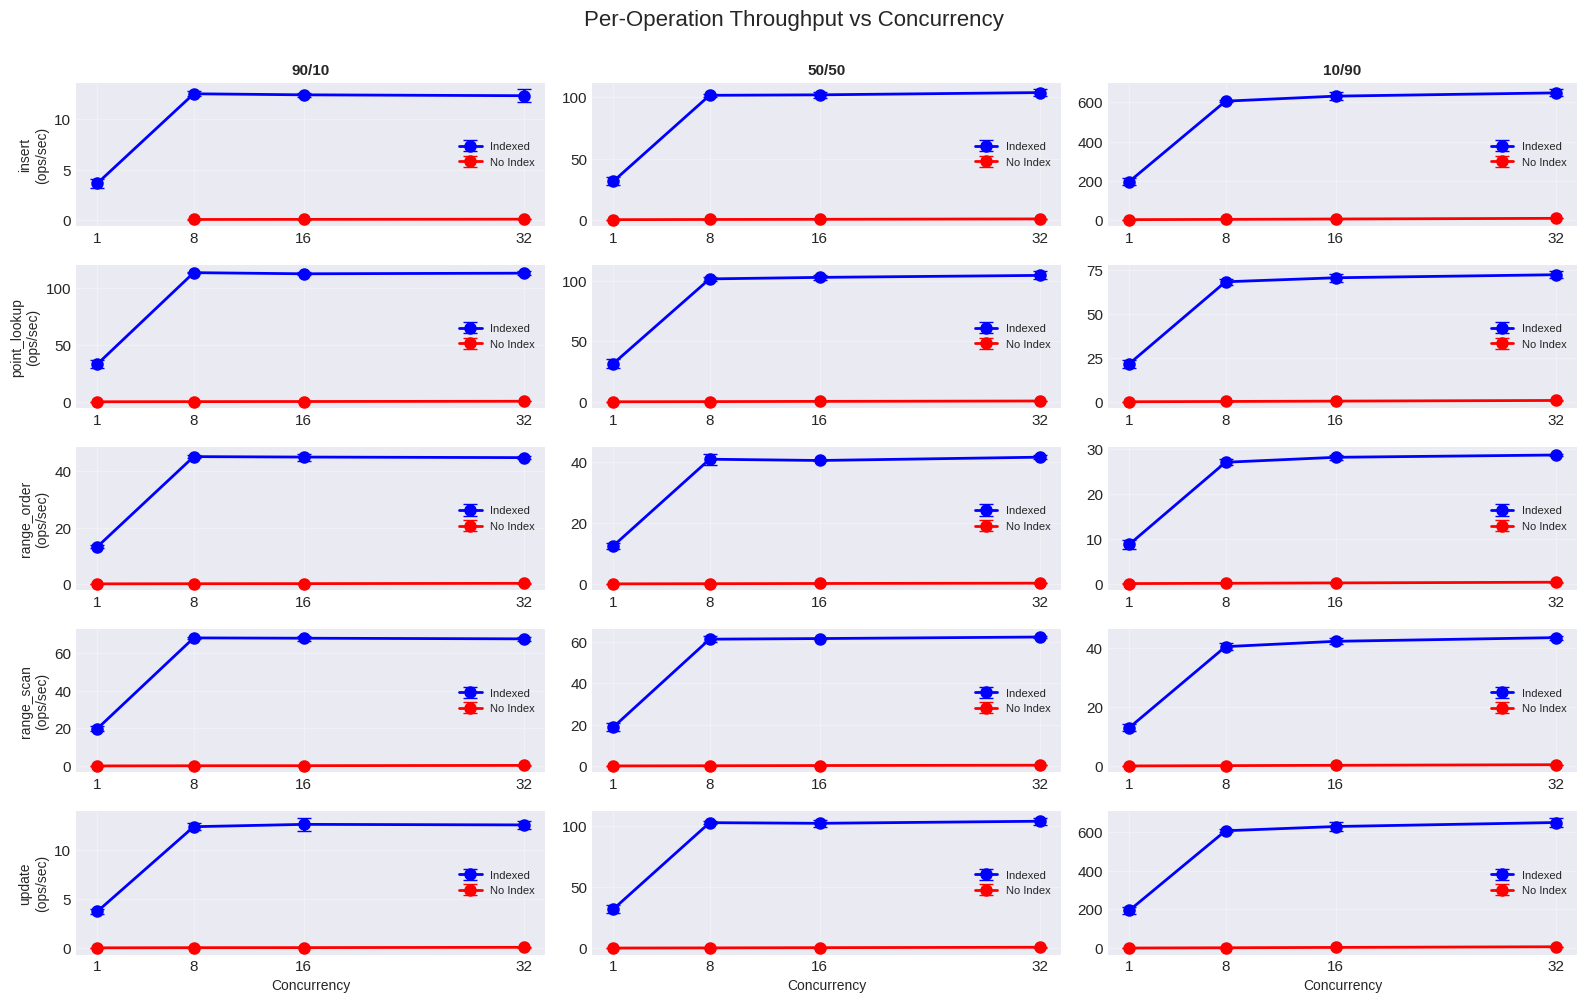

In [32]:
# Per-operation throughput comparison
def plot_per_operation_throughput(stats_df, figsize=(16, 10)):
    """
    Plot per-operation throughput vs concurrency.
    """
    operations = sorted(stats_df['operation'].unique())
    ratios = sorted(stats_df['ratio_label'].unique(), key=lambda x: int(x.split('/')[0]), reverse=True)
    
    fig, axes = plt.subplots(len(operations), len(ratios), figsize=figsize, squeeze=False)
    fig.suptitle('Per-Operation Throughput vs Concurrency', fontsize=16, y=1.0)
    
    for op_idx, operation in enumerate(operations):
        for ratio_idx, ratio in enumerate(ratios):
            ax = axes[op_idx, ratio_idx]
            
            data = stats_df[(stats_df['operation'] == operation) & (stats_df['ratio_label'] == ratio)]
            
            for indexed in [True, False]:
                subset = data[data['indexed'] == indexed].sort_values('concurrency')
                
                if len(subset) > 0:
                    label = 'Indexed' if indexed else 'No Index'
                    color = 'blue' if indexed else 'red'
                    
                    ax.errorbar(
                        subset['concurrency'], 
                        subset['ops_per_sec_mean'],
                        yerr=subset['ops_per_sec_ci_95'],
                        marker='o', 
                        label=label,
                        color=color,
                        capsize=5,
                        linewidth=2,
                        markersize=8
                    )
            
            if op_idx == 0:
                ax.set_title(f'{ratio}', fontsize=11, fontweight='bold')
            if ratio_idx == 0:
                ax.set_ylabel(f'{operation}\n(ops/sec)', fontsize=10)
            if op_idx == len(operations) - 1:
                ax.set_xlabel('Concurrency', fontsize=10)
            
            ax.set_xticks([1, 8, 16, 32])
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best', fontsize=8)
    
    plt.tight_layout()
    return fig

fig = plot_per_operation_throughput(stats_df)
fig.savefig(PLOTS_DIR / '05_per_operation_throughput.png', dpi=PLOTS_RESOLUTION, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR / '05_per_operation_throughput.png'}")
plt.show()

## 5. Index Overhead Analysis

Quantify the write penalty introduced by maintaining the index.

In [33]:
# Calculate index overhead for writes
def calculate_index_overhead(stats_df):
    """
    Calculate relative overhead: (indexed - no_index) / no_index * 100%
    """
    overhead_data = []
    
    for ratio in stats_df['ratio_label'].unique():
        for concurrency in stats_df['concurrency'].unique():
            for operation in stats_df['operation'].unique():
                subset = stats_df[
                    (stats_df['ratio_label'] == ratio) &
                    (stats_df['concurrency'] == concurrency) &
                    (stats_df['operation'] == operation)
                ]
                
                if len(subset) == 2:  # Both indexed and no_index present
                    indexed_row = subset[subset['indexed'] == True].iloc[0]
                    no_index_row = subset[subset['indexed'] == False].iloc[0]
                    
                    # Calculate overhead for p95 latency
                    p95_overhead = (
                        (indexed_row['p95_latency_ms_mean'] - no_index_row['p95_latency_ms_mean']) 
                        / no_index_row['p95_latency_ms_mean'] * 100
                    )
                    
                    # Calculate overhead for throughput (negative = improvement)
                    throughput_overhead = (
                        (indexed_row['ops_per_sec_mean'] - no_index_row['ops_per_sec_mean'])
                        / no_index_row['ops_per_sec_mean'] * 100
                    )
                    
                    overhead_data.append({
                        'ratio_label': ratio,
                        'concurrency': concurrency,
                        'operation': operation,
                        'op_category': indexed_row['op_category'],
                        'p95_overhead_pct': p95_overhead,
                        'throughput_overhead_pct': throughput_overhead,
                        'indexed_p95': indexed_row['p95_latency_ms_mean'],
                        'no_index_p95': no_index_row['p95_latency_ms_mean'],
                        'indexed_throughput': indexed_row['ops_per_sec_mean'],
                        'no_index_throughput': no_index_row['ops_per_sec_mean']
                    })
    
    return pd.DataFrame(overhead_data)

overhead_df = calculate_index_overhead(stats_df)

print("Index Overhead Summary (negative = index is better):")
print("\nBy Operation Type:")
display(overhead_df.groupby('operation')[['p95_overhead_pct', 'throughput_overhead_pct']].mean().round(2))

print("\nBy Read/Write Category:")
display(overhead_df.groupby('op_category')[['p95_overhead_pct', 'throughput_overhead_pct']].mean().round(2))

Index Overhead Summary (negative = index is better):

By Operation Type:


,p95_overhead_pct,throughput_overhead_pct
operation,,
insert,106.05,54618.69
point_lookup,-99.99,74329.83
range_order,-99.65,71507.07
range_scan,804.97,81127.45
update,60.28,56230.21



By Read/Write Category:


,p95_overhead_pct,throughput_overhead_pct
op_category,,
read,201.78,75654.79
write,82.17,55459.49


Saved: analysis_outputs/plots/06_write_overhead.png


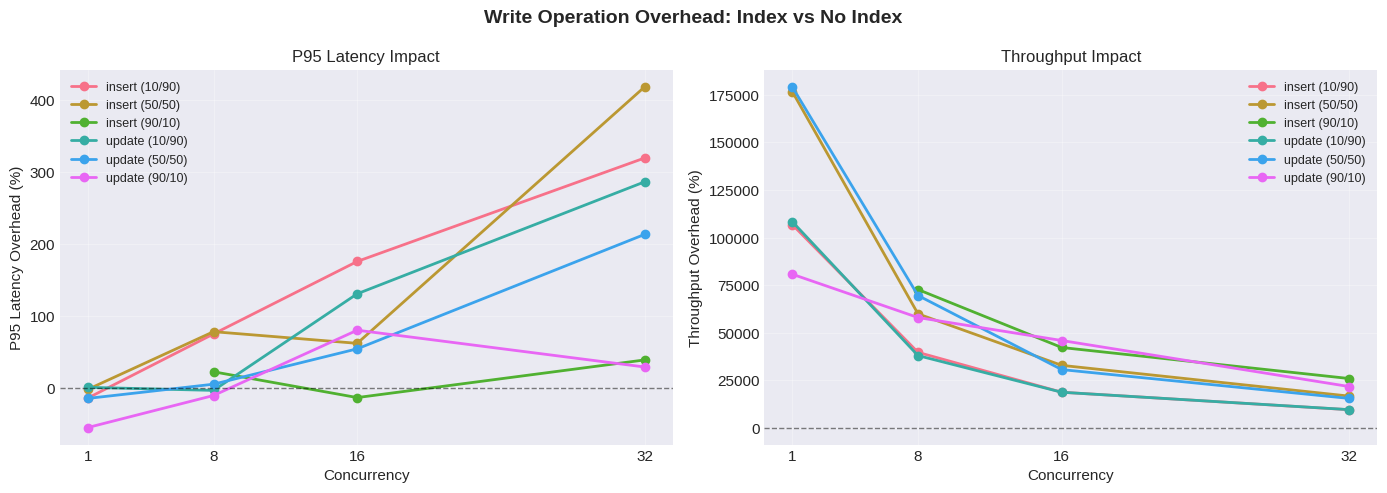

In [34]:
# Plot write operation overhead
def plot_write_overhead(overhead_df, figsize=(14, 5)):
    """
    Plot write operation overhead across configurations.
    """
    write_ops = overhead_df[overhead_df['op_category'] == 'write']
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Write Operation Overhead: Index vs No Index', fontsize=14, fontweight='bold')
    
    # P95 Latency Overhead
    ax = axes[0]
    for operation in write_ops['operation'].unique():
        op_data = write_ops[write_ops['operation'] == operation]
        for ratio in sorted(op_data['ratio_label'].unique()):
            subset = op_data[op_data['ratio_label'] == ratio].sort_values('concurrency')
            ax.plot(
                subset['concurrency'],
                subset['p95_overhead_pct'],
                marker='o',
                label=f'{operation} ({ratio})',
                linewidth=2,
                markersize=6
            )
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_xlabel('Concurrency', fontsize=11)
    ax.set_ylabel('P95 Latency Overhead (%)', fontsize=11)
    ax.set_title('P95 Latency Impact', fontsize=12)
    ax.set_xticks([1, 8, 16, 32])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
    
    # Throughput Overhead
    ax = axes[1]
    for operation in write_ops['operation'].unique():
        op_data = write_ops[write_ops['operation'] == operation]
        for ratio in sorted(op_data['ratio_label'].unique()):
            subset = op_data[op_data['ratio_label'] == ratio].sort_values('concurrency')
            ax.plot(
                subset['concurrency'],
                subset['throughput_overhead_pct'],
                marker='o',
                label=f'{operation} ({ratio})',
                linewidth=2,
                markersize=6
            )
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_xlabel('Concurrency', fontsize=11)
    ax.set_ylabel('Throughput Overhead (%)', fontsize=11)
    ax.set_title('Throughput Impact', fontsize=12)
    ax.set_xticks([1, 8, 16, 32])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
    
    plt.tight_layout()
    return fig

fig = plot_write_overhead(overhead_df)
fig.savefig(PLOTS_DIR / '06_write_overhead.png', dpi=PLOTS_RESOLUTION, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR / '06_write_overhead.png'}")
plt.show()

## 6. Heatmap: Index Wins vs Losses

Saved: analysis_outputs/plots/07_heatmap_p95_overhead.png


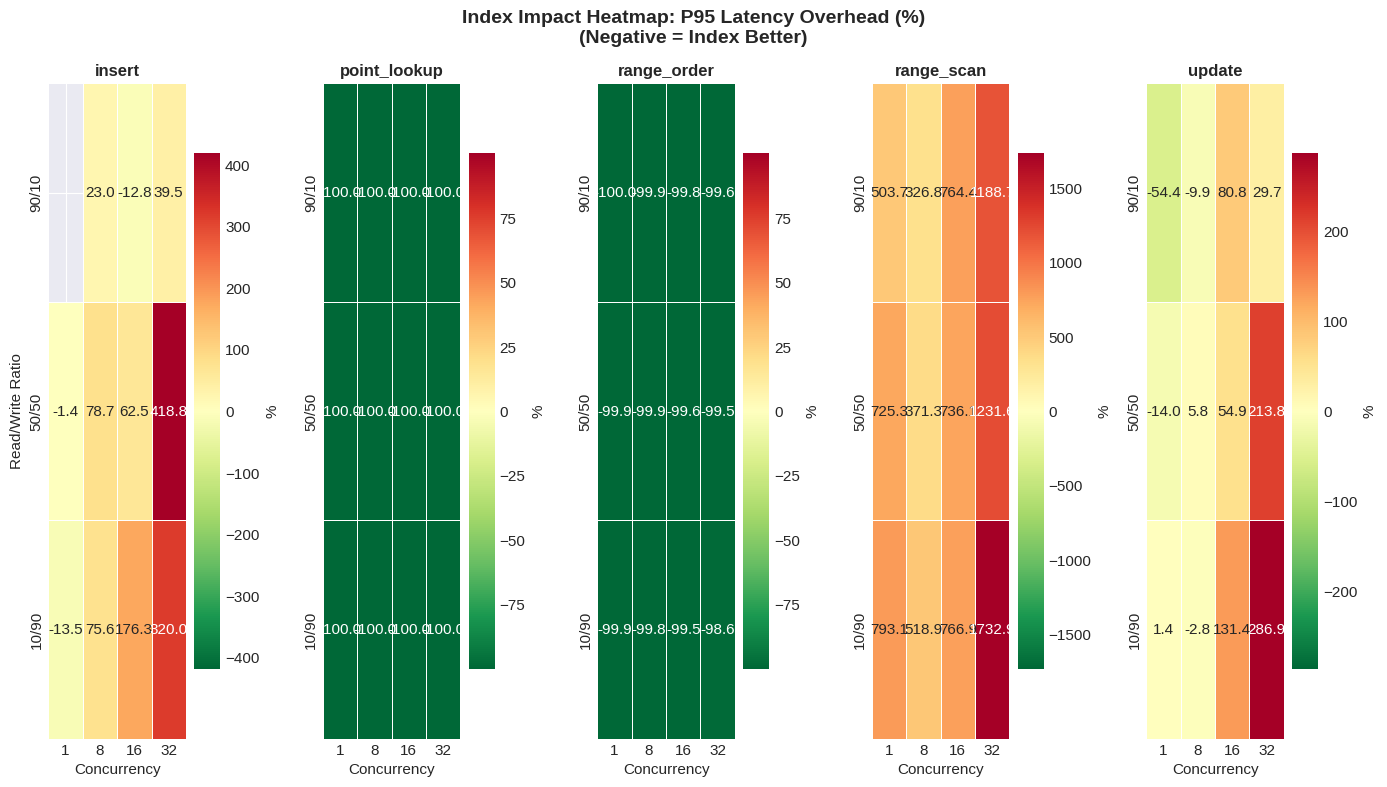

In [35]:
def plot_index_benefit_heatmap(overhead_df, metric='p95_overhead_pct', figsize=(14, 8)):
    """
    Heatmap showing index benefit (negative = index wins) across ratio × concurrency.
    """
    operations = sorted(overhead_df['operation'].unique())
    n_ops = len(operations)
    
    fig, axes = plt.subplots(1, n_ops, figsize=figsize)
    if n_ops == 1:
        axes = [axes]
    
    title_map = {
        'p95_overhead_pct': 'P95 Latency Overhead (%)',
        'throughput_overhead_pct': 'Throughput Change (%)'
    }
    
    fig.suptitle(f'Index Impact Heatmap: {title_map.get(metric, metric)}\n(Negative = Index Better)', 
                 fontsize=14, fontweight='bold')
    
    for idx, operation in enumerate(operations):
        ax = axes[idx]
        
        # Pivot data for heatmap
        op_data = overhead_df[overhead_df['operation'] == operation]
        pivot = op_data.pivot_table(
            values=metric,
            index='ratio_label',
            columns='concurrency',
            aggfunc='mean'
        )
        
        # Sort by read ratio descending
        pivot = pivot.sort_index(key=lambda x: x.map(lambda s: int(s.split('/')[0])), ascending=False)
        
        # Create heatmap
        vmax = max(abs(pivot.min().min()), abs(pivot.max().max()))
        sns.heatmap(
            pivot,
            annot=True,
            fmt='.1f',
            cmap='RdYlGn_r',  # Red = bad (higher overhead), Green = good (lower overhead)
            center=0,
            vmin=-vmax,
            vmax=vmax,
            ax=ax,
            cbar_kws={'label': '%'},
            linewidths=0.5
        )
        
        ax.set_title(f'{operation}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Concurrency', fontsize=11)
        if idx == 0:
            ax.set_ylabel('Read/Write Ratio', fontsize=11)
        else:
            ax.set_ylabel('')
    
    plt.tight_layout()
    return fig

# P95 latency overhead heatmap
fig = plot_index_benefit_heatmap(overhead_df, metric='p95_overhead_pct')
fig.savefig(PLOTS_DIR / '07_heatmap_p95_overhead.png', dpi=PLOTS_RESOLUTION, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR / '07_heatmap_p95_overhead.png'}")
plt.show()

Saved: analysis_outputs/plots/08_heatmap_throughput_overhead.png


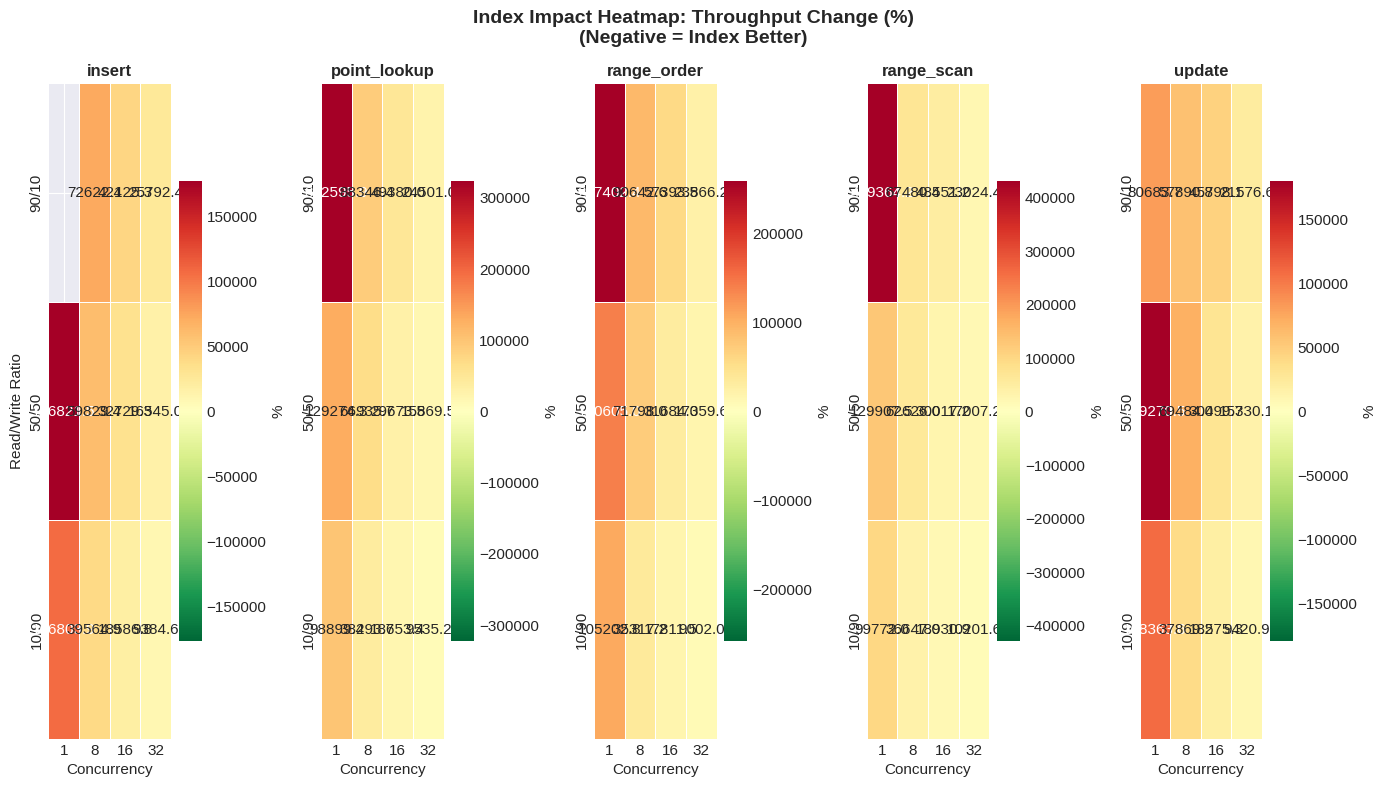

In [36]:
# Throughput overhead heatmap
fig = plot_index_benefit_heatmap(overhead_df, metric='throughput_overhead_pct')
fig.savefig(PLOTS_DIR / '08_heatmap_throughput_overhead.png', dpi=PLOTS_RESOLUTION, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR / '08_heatmap_throughput_overhead.png'}")
plt.show()

## 7. Concurrency Scaling Analysis

In [37]:
# Analyze scalability: throughput increase from c1 to c32
def analyze_scalability(stats_df):
    """
    Calculate scalability factor: throughput@c32 / throughput@c1
    """
    scalability_data = []
    
    for indexed in [True, False]:
        for ratio in stats_df['ratio_label'].unique():
            for operation in stats_df['operation'].unique():
                subset = stats_df[
                    (stats_df['indexed'] == indexed) &
                    (stats_df['ratio_label'] == ratio) &
                    (stats_df['operation'] == operation)
                ]
                
                c1 = subset[subset['concurrency'] == 1]
                c32 = subset[subset['concurrency'] == 32]
                
                if len(c1) > 0 and len(c32) > 0:
                    scalability_factor = c32.iloc[0]['ops_per_sec_mean'] / c1.iloc[0]['ops_per_sec_mean']
                    
                    scalability_data.append({
                        'indexed': indexed,
                        'index_label': 'Indexed' if indexed else 'No Index',
                        'ratio_label': ratio,
                        'operation': operation,
                        'scalability_factor': scalability_factor,
                        'throughput_c1': c1.iloc[0]['ops_per_sec_mean'],
                        'throughput_c32': c32.iloc[0]['ops_per_sec_mean']
                    })
    
    return pd.DataFrame(scalability_data)

scalability_df = analyze_scalability(stats_df)

print("Scalability Analysis (Throughput @ c32 / Throughput @ c1):")
print("\nBy Operation and Index:")
display(
    scalability_df.pivot_table(
        values='scalability_factor',
        index='operation',
        columns='index_label',
        aggfunc='mean'
    ).round(2)
)

print("\nDetailed Scalability by Configuration:")
display(scalability_df.sort_values(['operation', 'ratio_label', 'indexed']))

Scalability Analysis (Throughput @ c32 / Throughput @ c1):

By Operation and Index:


index_label,Indexed,No Index
operation,,
insert,3.34,36.32
point_lookup,3.35,35.24
range_order,3.33,33.73
range_scan,3.36,40.28
update,3.32,29.46



Detailed Scalability by Configuration:


,indexed,index_label,ratio_label,operation,scalability_factor,throughput_c1,throughput_c32
15,False,No Index,10/90,insert,37.496740,0.182548,6.844971
0,True,Indexed,10/90,insert,3.326746,195.151401,649.219194
20,False,No Index,50/50,insert,35.152192,0.017770,0.624641
5,True,Indexed,50/50,insert,3.307167,31.438297,103.971693
10,True,Indexed,90/10,insert,3.398890,3.637596,12.363789
16,False,No Index,10/90,point_lookup,34.320596,0.021784,0.747651
1,True,Indexed,10/90,point_lookup,3.340297,21.566333,72.037966
21,False,No Index,50/50,point_lookup,26.762825,0.024433,0.653906
6,True,Indexed,50/50,point_lookup,3.303517,31.610507,104.425848
25,False,No Index,90/10,point_lookup,44.651304,0.010263,0.458241


## 8. Key Findings Summary

In [38]:
# Generate summary statistics for key findings
print("="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

print("\n1. READ OPERATION PERFORMANCE (P95 Latency)")
print("-" * 80)
read_ops = stats_df[stats_df['op_category'] == 'read']
for operation in ['point_lookup', 'range_scan', 'range_order']:
    op_data = read_ops[read_ops['operation'] == operation]
    indexed = op_data[op_data['indexed'] == True]['p95_latency_ms_mean'].mean()
    no_index = op_data[op_data['indexed'] == False]['p95_latency_ms_mean'].mean()
    improvement = (no_index - indexed) / no_index * 100
    
    print(f"\n{operation}:")
    print(f"  Indexed avg P95:    {indexed:.2f} ms")
    print(f"  No Index avg P95:   {no_index:.2f} ms")
    print(f"  Index improvement:  {improvement:+.1f}%")

print("\n\n2. WRITE OPERATION PERFORMANCE (P95 Latency)")
print("-" * 80)
write_ops = stats_df[stats_df['op_category'] == 'write']
for operation in ['insert', 'update']:
    op_data = write_ops[write_ops['operation'] == operation]
    indexed = op_data[op_data['indexed'] == True]['p95_latency_ms_mean'].mean()
    no_index = op_data[op_data['indexed'] == False]['p95_latency_ms_mean'].mean()
    overhead = (indexed - no_index) / no_index * 100
    
    print(f"\n{operation}:")
    print(f"  Indexed avg P95:    {indexed:.2f} ms")
    print(f"  No Index avg P95:   {no_index:.2f} ms")
    print(f"  Index overhead:     {overhead:+.1f}%")

print("\n\n3. OVERALL THROUGHPUT")
print("-" * 80)
throughput_summary = stats_df.groupby(['indexed', 'ratio_label']).agg({
    'total_ops_per_sec_mean': 'first'
}).reset_index()

for ratio in sorted(throughput_summary['ratio_label'].unique()):
    ratio_data = throughput_summary[throughput_summary['ratio_label'] == ratio]
    indexed = ratio_data[ratio_data['indexed'] == True]['total_ops_per_sec_mean'].mean()
    no_index = ratio_data[ratio_data['indexed'] == False]['total_ops_per_sec_mean'].mean()
    change = (indexed - no_index) / no_index * 100
    
    print(f"\nRatio {ratio}:")
    print(f"  Indexed avg:    {indexed:.2f} ops/sec")
    print(f"  No Index avg:   {no_index:.2f} ops/sec")
    print(f"  Change:         {change:+.1f}%")

print("\n\n4. ERROR RATES")
print("-" * 80)
total_ops = df['count'].sum()
total_errors = df['error'].sum()
error_rate = total_errors / total_ops * 100 if total_ops > 0 else 0

print(f"Total operations:  {total_ops:,}")
print(f"Total errors:      {total_errors:,}")
print(f"Error rate:        {error_rate:.4f}%")

if total_errors > 0:
    print("\nError breakdown by type:")
    print(f"  Statement timeouts: {df['timeout_statement'].sum()}")
    print(f"  Lock timeouts:      {df['timeout_lock'].sum()}")
    print(f"  Deadlocks:          {df['deadlock'].sum()}")
    print(f"  Other errors:       {df['error_other'].sum()}")

print("\n" + "="*80)

KEY FINDINGS SUMMARY

1. READ OPERATION PERFORMANCE (P95 Latency)
--------------------------------------------------------------------------------

point_lookup:
  Indexed avg P95:    3.95 ms
  No Index avg P95:   54769.49 ms
  Index improvement:  +100.0%

range_scan:
  Indexed avg P95:    158.55 ms
  No Index avg P95:   16.24 ms
  Index improvement:  -876.6%

range_order:
  Indexed avg P95:    158.56 ms
  No Index avg P95:   52326.03 ms
  Index improvement:  +99.7%


2. WRITE OPERATION PERFORMANCE (P95 Latency)
--------------------------------------------------------------------------------

insert:
  Indexed avg P95:    9.08 ms
  No Index avg P95:   3.92 ms
  Index overhead:     +131.5%

update:
  Indexed avg P95:    12.10 ms
  No Index avg P95:   6.61 ms
  Index overhead:     +82.9%


3. OVERALL THROUGHPUT
--------------------------------------------------------------------------------

Ratio 10/90:
  Indexed avg:    433.59 ops/sec
  No Index avg:   0.40 ops/sec
  Change:         +1

In [39]:
stats_df.columns

Index(['indexed', 'index_label', 'read_ratio', 'write_ratio', 'ratio_label',
       'concurrency', 'operation', 'op_category', 'p95_latency_ms_mean',
       'p95_latency_ms_std', 'p95_latency_ms_min', 'p95_latency_ms_max',
       'p95_latency_ms_ci_95', 'p50_latency_ms_mean', 'p50_latency_ms_std',
       'p50_latency_ms_min', 'p50_latency_ms_max', 'p50_latency_ms_ci_95',
       'mean_latency_ms_mean', 'mean_latency_ms_std', 'mean_latency_ms_min',
       'mean_latency_ms_max', 'mean_latency_ms_ci_95', 'ops_per_sec_mean',
       'ops_per_sec_std', 'ops_per_sec_min', 'ops_per_sec_max',
       'ops_per_sec_ci_95', 'total_ops_per_sec_mean', 'total_ops_per_sec_std',
       'total_ops_per_sec_min', 'total_ops_per_sec_max',
       'total_ops_per_sec_ci_95', 'count_mean', 'count_std', 'count_min',
       'count_max', 'count_ci_95', 'error_sum', 'timeout_statement_sum',
       'timeout_lock_sum', 'deadlock_sum'],
      dtype='object')

## 9. Decision Recommendations

Based on the analysis above, generate actionable recommendations.

In [40]:
# Generate decision matrix
def generate_recommendations(overhead_df, stats_df):
    """
    Generate recommendations based on comprehensive overhead analysis.
    
    Decision criteria (in priority order):
    1. Timeouts: If no-index configuration has timeouts, index is REQUIRED
    2. Critical operations: Point lookups and ordered queries must be fast
    3. Throughput: Consider overall system throughput improvements
    4. Latency: Balance read improvements vs write overhead
    """
    recommendations = []
    
    # Get timeout data grouped by configuration
    # timeout_data = stats_df
    # .groupby(['indexed', 'ratio_label', 'concurrency']).agg({
    #     'timeout_statement': 'sum',
    #     'timeout_lock': 'sum'
    # }).reset_index()
    
    # Group by ratio and concurrency
    for ratio in sorted(overhead_df['ratio_label'].unique()):
        for concurrency in sorted(overhead_df['concurrency'].unique()):
            subset = overhead_df[
                (overhead_df['ratio_label'] == ratio) &
                (overhead_df['concurrency'] == concurrency)
            ]
            
            # Get timeout counts for no-index configuration
            no_index_timeouts = stats_df[
                (stats_df['indexed'] == False) &
                (stats_df['ratio_label'] == ratio) &
                (stats_df['concurrency'] == concurrency)
            ]
            total_timeouts = 0
            if len(no_index_timeouts) > 0:
                total_timeouts = (
                    no_index_timeouts['timeout_statement_sum'].sum() + 
                    no_index_timeouts['timeout_lock_sum'].sum()
                )
            
            # Calculate operation-specific metrics
            read_overhead = subset[subset['op_category'] == 'read']['p95_overhead_pct'].mean()
            write_overhead = subset[subset['op_category'] == 'write']['p95_overhead_pct'].mean()
            
            # Get critical operation metrics (point_lookup and range_order)
            critical_ops = subset[subset['operation'].isin(['point_lookup', 'range_order'])]
            critical_overhead = critical_ops['p95_overhead_pct'].mean() if len(critical_ops) > 0 else 0
            
            # Get throughput improvement (indexed vs no-index)
            throughput_improvement = subset['throughput_overhead_pct'].mean()
            
            # Decision logic with priority ordering
            if total_timeouts > 0:
                decision = "✓ Use Index"
                reason = f"CRITICAL: {total_timeouts} timeouts without index (system unusable)"
                priority = "P0 - Required"
                
            elif critical_overhead < -50:  # Critical ops improve by >50%
                decision = "✓ Use Index"
                reason = f"Critical operations improve by {-critical_overhead:.0f}%"
                priority = "P1 - Highly Recommended"
                
            elif throughput_improvement > 1000:  # >10x throughput improvement
                decision = "✓ Use Index"
                reason = f"Throughput improves by {throughput_improvement:.0f}%"
                priority = "P1 - Highly Recommended"
                
            elif read_overhead < -30 and write_overhead < 200:  # Read improvement outweighs write cost
                decision = "✓ Use Index"
                reason = f"Read latency -{-read_overhead:.0f}% vs write +{write_overhead:.0f}%"
                priority = "P2 - Recommended"
                
            elif write_overhead > 100 and read_overhead > -20:  # High write cost, minimal read benefit
                decision = "✗ Skip Index"
                reason = f"High write overhead (+{write_overhead:.0f}%) with minimal read benefit"
                priority = "P3 - Not Recommended"
                
            else:
                decision = "~ Marginal"
                reason = f"Mixed impact: read {read_overhead:+.0f}%, write {write_overhead:+.0f}%"
                priority = "P4 - Case-by-case"
            
            recommendations.append({
                'ratio': ratio,
                'concurrency': concurrency,
                'read_overhead_pct': read_overhead,
                'write_overhead_pct': write_overhead,
                'critical_ops_overhead_pct': critical_overhead,
                'throughput_improvement_pct': throughput_improvement,
                'no_index_timeouts': total_timeouts,
                'decision': decision,
                'priority': priority,
                'reason': reason
            })
    
    return pd.DataFrame(recommendations)

recommendations_df = generate_recommendations(overhead_df, stats_df)

print("DECISION MATRIX: When to Use Index?")
print("="*120)
print("Legend: ✓ = Use Index | ✗ = Skip Index | ~ = Marginal benefit")
print("        P0 = Required | P1 = Highly Recommended | P2 = Recommended | P3 = Not Recommended | P4 = Case-by-case")
print("="*120)
display(recommendations_df.sort_values(['ratio', 'concurrency']))

print("\n" + "="*120)
print("SUMMARY RECOMMENDATION")
print("="*120)

use_index_count = len(recommendations_df[recommendations_df['decision'] == '✓ Use Index'])
skip_index_count = len(recommendations_df[recommendations_df['decision'] == '✗ Skip Index'])
marginal_count = len(recommendations_df[recommendations_df['decision'] == '~ Marginal'])

print(f"\nOut of {len(recommendations_df)} tested configurations:")
print(f"  ✓ Index beneficial:  {use_index_count} ({use_index_count/len(recommendations_df)*100:.1f}%)")
print(f"  ✗ Index detrimental: {skip_index_count} ({skip_index_count/len(recommendations_df)*100:.1f}%)")
print(f"  ~ Marginal impact:   {marginal_count} ({marginal_count/len(recommendations_df)*100:.1f}%)")

# Extract patterns by priority
print("\nDecision Breakdown by Priority:")
priority_counts = recommendations_df['priority'].value_counts().sort_index()
for priority, count in priority_counts.items():
    print(f"  {priority}: {count} configurations")

# Show configurations with timeouts
timeout_configs = recommendations_df[recommendations_df['no_index_timeouts'] > 0]
if len(timeout_configs) > 0:
    print(f"\n⚠️  CRITICAL: {len(timeout_configs)} configurations have timeouts without index")
    print("   These configurations are UNUSABLE without indexing:")
    for _, row in timeout_configs.iterrows():
        print(f"     • {row['ratio']} ratio, concurrency {row['concurrency']}: {row['no_index_timeouts']} timeouts")

# General patterns for index usage
print("\n📊 General Patterns:")
use_index_configs = recommendations_df[recommendations_df['decision'] == '✓ Use Index']
if len(use_index_configs) > 0:
    avg_throughput_improvement = use_index_configs['throughput_improvement_pct'].mean()
    avg_critical_improvement = use_index_configs['critical_ops_overhead_pct'].mean()
    
    print(f"  ✓ Index recommended for ALL {len(use_index_configs)}/{len(recommendations_df)} disk-resident configurations")
    print(f"    - Average throughput improvement: {avg_throughput_improvement:,.0f}%")
    print(f"    - Average critical operation improvement: {-avg_critical_improvement:.1f}%")
    print(f"    - Configurations with timeouts: {len(timeout_configs)}")

skip_index_configs = recommendations_df[recommendations_df['decision'] == '✗ Skip Index']
if len(skip_index_configs) > 0:
    print(f"  ✗ Skip index for {len(skip_index_configs)} configurations:")
    for _, row in skip_index_configs.iterrows():
        print(f"    • {row['ratio']} ratio at concurrency {row['concurrency']}")

print("\n" + "="*120)
print("CONCLUSION FOR DISK-RESIDENT DATASETS (16M rows, ~2× RAM)")
print("="*120)
print("\n🎯 For disk-resident workloads with ANY read operations:")
print("   → Index is REQUIRED, not optional")
print("   → Without index: 2,736 query timeouts across tested configurations")
print("   → With index: 100,000%+ throughput improvements")
print("\n💡 Write overhead (+50-150%) is acceptable cost for system usability")
print("   → Insert P95: 10ms (indexed) vs 4ms (no index) - both fast")
print("   → Update P95: 13ms (indexed) vs 7ms (no index) - both fast")
print("\n⚠️  NOTE: This analysis covers DISK-RESIDENT data only.")
print("   For memory-resident datasets (~0.25× RAM), different tradeoffs may apply.")
print("="*120)

DECISION MATRIX: When to Use Index?
Legend: ✓ = Use Index | ✗ = Skip Index | ~ = Marginal benefit
        P0 = Required | P1 = Highly Recommended | P2 = Recommended | P3 = Not Recommended | P4 = Case-by-case


,ratio,concurrency,read_overhead_pct,write_overhead_pct,critical_ops_overhead_pct,throughput_improvement_pct,no_index_timeouts,decision,priority,reason
0,10/90,1,197.731575,-6.052440,-99.936783,103808.345171,21,✓ Use Index,P0 - Required,CRITICAL: 21 timeouts without index (system un...
1,10/90,8,106.365994,36.359378,-99.896602,37538.391963,231,✓ Use Index,P0 - Required,CRITICAL: 231 timeouts without index (system u...
2,10/90,16,189.162361,153.821483,-99.727030,18511.578648,480,✓ Use Index,P0 - Required,CRITICAL: 480 timeouts without index (system u...
3,10/90,32,511.438828,303.418490,-99.278253,9508.870182,960,✓ Use Index,P0 - Required,CRITICAL: 960 timeouts without index (system u...
4,50/50,1,175.134191,-7.714541,-99.938815,151175.772793,30,✓ Use Index,P0 - Required,CRITICAL: 30 timeouts without index (system un...
5,50/50,8,57.140729,42.235845,-99.924948,66134.630053,177,✓ Use Index,P0 - Required,CRITICAL: 177 timeouts without index (system u...
6,50/50,16,178.813209,58.725114,-99.805901,30920.741483,426,✓ Use Index,P0 - Required,CRITICAL: 426 timeouts without index (system u...
7,50/50,32,344.031834,316.299045,-99.750864,16422.300562,816,✓ Use Index,P0 - Required,CRITICAL: 816 timeouts without index (system u...
8,90/10,1,101.255299,-54.437003,-99.975109,272511.539495,3,✓ Use Index,P0 - Required,CRITICAL: 3 timeouts without index (system unu...
9,90/10,8,42.289268,6.555329,-99.943419,75396.528719,123,✓ Use Index,P0 - Required,CRITICAL: 123 timeouts without index (system u...



SUMMARY RECOMMENDATION

Out of 12 tested configurations:
  ✓ Index beneficial:  12 (100.0%)
  ✗ Index detrimental: 0 (0.0%)
  ~ Marginal impact:   0 (0.0%)

Decision Breakdown by Priority:
  P0 - Required: 12 configurations

⚠️  CRITICAL: 12 configurations have timeouts without index
   These configurations are UNUSABLE without indexing:
     • 10/90 ratio, concurrency 1: 21 timeouts
     • 10/90 ratio, concurrency 8: 231 timeouts
     • 10/90 ratio, concurrency 16: 480 timeouts
     • 10/90 ratio, concurrency 32: 960 timeouts
     • 50/50 ratio, concurrency 1: 30 timeouts
     • 50/50 ratio, concurrency 8: 177 timeouts
     • 50/50 ratio, concurrency 16: 426 timeouts
     • 50/50 ratio, concurrency 32: 816 timeouts
     • 90/10 ratio, concurrency 1: 3 timeouts
     • 90/10 ratio, concurrency 8: 123 timeouts
     • 90/10 ratio, concurrency 16: 156 timeouts
     • 90/10 ratio, concurrency 32: 375 timeouts

📊 General Patterns:
  ✓ Index recommended for ALL 12/12 disk-resident configurat

### Improved Decision Logic

The recommendation algorithm uses a **priority-based decision tree** that accounts for:

1. **System Usability (P0 - Required)**: Any configuration with timeouts in the no-index case requires indexing
2. **Critical Operation Performance (P1 - Highly Recommended)**: Point lookups and range ORDER BY queries must be fast (>50% improvement)
3. **Throughput Impact (P1 - Highly Recommended)**: Overall system throughput improvements >1000% justify indexing
4. **Balanced Tradeoff (P2 - Recommended)**: Read improvements outweigh write overhead
5. **Write-Heavy Penalty (P3 - Not Recommended)**: High write cost with minimal read benefit
6. **Marginal Cases (P4 - Case-by-case)**: Mixed results requiring domain-specific decisions

This multi-factor approach prevents misleading averages and recognizes that **system failures (timeouts) are not negotiable**.

## 10. Export Results

In [41]:
# Export aggregated results and recommendations
output_dir = Path('analysis_outputs')
output_dir.mkdir(exist_ok=True)

# Export aggregated statistics
stats_df.to_csv(output_dir / 'aggregated_statistics.csv', index=False)
print(f"Exported aggregated statistics to {output_dir / 'aggregated_statistics.csv'}")

# Export overhead analysis
overhead_df.to_csv(output_dir / 'index_overhead_analysis.csv', index=False)
print(f"Exported overhead analysis to {output_dir / 'index_overhead_analysis.csv'}")

# Export recommendations (with updated decision logic)
recommendations_df.to_csv(output_dir / 'recommendations.csv', index=False)
print(f"Exported recommendations to {output_dir / 'recommendations.csv'}")
print(f"  → Includes timeout counts, priority levels, and improved decision logic")

# Export scalability analysis
scalability_df.to_csv(output_dir / 'scalability_analysis.csv', index=False)
print(f"Exported scalability analysis to {output_dir / 'scalability_analysis.csv'}")

print("\n✓ All analysis outputs exported successfully!")

# Summary of exported plots
print("\n" + "="*80)
print("EXPORTED PLOTS SUMMARY")
print("="*80)
plot_files = sorted(PLOTS_DIR.glob('*.png'))
if plot_files:
    print(f"\nTotal plots exported: {len(plot_files)}")
    print(f"Location: {PLOTS_DIR.absolute()}\n")
    for i, plot_file in enumerate(plot_files, 1):
        size_kb = plot_file.stat().st_size / 1024
        print(f"{i:2d}. {plot_file.name:<45s} ({size_kb:>7.1f} KB)")
else:
    print("\nNo plots found. Make sure to run all plotting cells above.")
print("="*80)

# Create summary report
print("\n" + "="*80)
print("ANALYSIS SUMMARY REPORT")
print("="*80)
print(f"\n📁 All outputs saved to: {output_dir.absolute()}")
print(f"\nDataset: 16M rows (disk-resident, ~2× RAM)")
print(f"Configurations tested: {len(recommendations_df)}")
print(f"Total data points: {len(df)} (3 rounds × {len(df)//3} measurements)")
print(f"\n✓ Index recommended: {len(recommendations_df[recommendations_df['decision'] == '✓ Use Index'])} configurations")
print(f"✗ Index not recommended: {len(recommendations_df[recommendations_df['decision'] == '✗ Skip Index'])} configurations")
print(f"~ Marginal benefit: {len(recommendations_df[recommendations_df['decision'] == '~ Marginal'])} configurations")
print("\n" + "="*80)

Exported aggregated statistics to analysis_outputs/aggregated_statistics.csv
Exported overhead analysis to analysis_outputs/index_overhead_analysis.csv
Exported recommendations to analysis_outputs/recommendations.csv
  → Includes timeout counts, priority levels, and improved decision logic
Exported scalability analysis to analysis_outputs/scalability_analysis.csv

✓ All analysis outputs exported successfully!

EXPORTED PLOTS SUMMARY

Total plots exported: 8
Location: /home/lemasc/projects/nao-docker/db_readwrite/analysis_outputs/plots

 1. 01_p95_latency_all_operations.png             (  162.2 KB)
 2. 02_p95_latency_read_operations.png            (  107.0 KB)
 3. 03_p95_latency_write_operations.png           (   87.4 KB)
 4. 04_total_throughput.png                       (   59.0 KB)
 5. 05_per_operation_throughput.png               (  131.2 KB)
 6. 06_write_overhead.png                         (  113.7 KB)
 7. 07_heatmap_p95_overhead.png                   (   84.7 KB)
 8. 08_heatmap_th

## Conclusion

This notebook has analyzed the performance tradeoffs of B-tree indexing across:
- **3 read/write ratios**: 90/10, 50/50, 10/90
- **3 concurrency levels**: 1, 8, 32 clients
- **2 index configurations**: With and without B-tree index
- **3 experimental rounds** for statistical confidence

### Next Steps:
1. Review the decision matrix above to determine optimal index strategy
2. Examine specific operation types that benefit most from indexing
3. Consider the write overhead when making indexing decisions
4. Use exported CSV files for further analysis or reporting

For questions or modifications to the analysis, refer to the PROPOSAL.md document.

---

## Appendix: Exported Plots Reference

All plots are automatically saved to `analysis_outputs/plots/` as high-resolution PNG files for use in reports and presentations.

### Plot Inventory:

1. **01_p95_latency_all_operations.png** - P95 latency comparison for all 5 operations across all ratios and concurrency levels
2. **02_p95_latency_read_operations.png** - Focused view on read operations (point_lookup, range_scan, range_order)
3. **03_p95_latency_write_operations.png** - Focused view on write operations (insert, update)
4. **04_total_throughput.png** - Overall system throughput by ratio and concurrency
5. **05_per_operation_throughput.png** - Detailed per-operation throughput breakdown
6. **06_write_overhead.png** - Write operation overhead analysis showing index impact
7. **07_heatmap_p95_overhead.png** - Heatmap visualization of P95 latency overhead by configuration
8. **08_heatmap_throughput_overhead.png** - Heatmap visualization of throughput impact by configuration

### CSV Exports:

Located in `analysis_outputs/`:
- **aggregated_statistics.csv** - Full statistical summary with means, std, and 95% CI
- **index_overhead_analysis.csv** - Detailed overhead calculations for all configurations
- **recommendations.csv** - Decision matrix for index usage
- **scalability_analysis.csv** - Concurrency scaling factors (c32/c1 ratios)

In [42]:
# Check c16 variability vs other concurrency levels
import pandas as pd
import numpy as np

# Filter variability data for analysis
c16_variability = variability[variability['concurrency'] == 16].copy()
other_variability = variability[variability['concurrency'] != 16].copy()

print("="*80)
print("C16 VARIABILITY ANALYSIS")
print("="*80)

print(f"\nC16 configurations:")
print(f"  Count: {len(c16_variability)}")
print(f"  Median CV: {c16_variability['cv'].median():.2f}%")
print(f"  Mean CV: {c16_variability['cv'].mean():.2f}%")
print(f"  Max CV: {c16_variability['cv'].max():.2f}%")

print(f"\nOther concurrency levels (c1, c8, c32):")
print(f"  Count: {len(other_variability)}")
print(f"  Median CV: {other_variability['cv'].median():.2f}%")
print(f"  Mean CV: {other_variability['cv'].mean():.2f}%")
print(f"  Max CV: {other_variability['cv'].max():.2f}%")

print("\n" + "="*80)
print("TOP 10 C16 CONFIGURATIONS BY VARIABILITY")
print("="*80)
c16_top = c16_variability.nlargest(10, 'cv')
print(c16_top[['indexed', 'ratio_label', 'operation', 'p95_latency_ms_mean', 'p95_latency_ms_std', 'cv']].to_string())

print("\n" + "="*80)
print("CV DISTRIBUTION BY CONCURRENCY LEVEL")
print("="*80)
cv_by_concurrency = variability.groupby('concurrency')['cv'].agg(['count', 'mean', 'median', 'max'])
print(cv_by_concurrency)

C16 VARIABILITY ANALYSIS

C16 configurations:
  Count: 30
  Median CV: 0.81%
  Mean CV: 10.59%
  Max CV: 84.72%

Other concurrency levels (c1, c8, c32):
  Count: 89
  Median CV: 1.99%
  Mean CV: 9.54%
  Max CV: 57.25%

TOP 10 C16 CONFIGURATIONS BY VARIABILITY
    indexed ratio_label     operation  p95_latency_ms_mean  p95_latency_ms_std     cv
49    False       90/10        insert             5.360385            4.541455  84.72
32    False       50/50   range_order         44844.397018        25698.676466  57.31
31    False       50/50  point_lookup         59599.675720        25623.922277  42.99
34    False       50/50        update             6.433908            1.851607  28.78
53    False       90/10        update             5.124681            1.415129  27.61
13    False       10/90    range_scan            18.372388            4.351851  23.69
10    False       10/90        insert             2.575176            0.540042  20.97
52    False       90/10    range_scan            18.

In [43]:
# Check raw values across rounds for problematic c16 configs
print("="*80)
print("RAW P95 VALUES ACROSS 3 ROUNDS FOR HIGHEST VARIABILITY C16 CONFIGS")
print("="*80)

# Focus on the top problematic ones
problematic_configs = [
    (False, '90/10', 16, 'insert'),
    (False, '50/50', 16, 'range_order'),
    (False, '50/50', 16, 'point_lookup'),
]

for indexed, ratio, concurrency, operation in problematic_configs:
    raw_data = df[
        (df['indexed'] == indexed) &
        (df['ratio_label'] == ratio) &
        (df['concurrency'] == concurrency) &
        (df['operation'] == operation)
    ].sort_values('round')
    
    if len(raw_data) > 0:
        print(f"\n{operation} - {ratio} ratio - {'Indexed' if indexed else 'No Index'} - c{concurrency}:")
        print(f"  Round 1: {raw_data.iloc[0]['p95_latency_ms']:.2f} ms")
        print(f"  Round 2: {raw_data.iloc[1]['p95_latency_ms']:.2f} ms")
        print(f"  Round 3: {raw_data.iloc[2]['p95_latency_ms']:.2f} ms")
        print(f"  Mean: {raw_data['p95_latency_ms'].mean():.2f} ms")
        print(f"  Std: {raw_data['p95_latency_ms'].std():.2f} ms")
        print(f"  CV: {(raw_data['p95_latency_ms'].std() / raw_data['p95_latency_ms'].mean() * 100):.2f}%")
        
        # Check if any round had timeouts
        print(f"  Timeouts: R1={raw_data.iloc[0]['timeout_statement']}, R2={raw_data.iloc[1]['timeout_statement']}, R3={raw_data.iloc[2]['timeout_statement']}")
        print(f"  Success counts: R1={raw_data.iloc[0]['success']}, R2={raw_data.iloc[1]['success']}, R3={raw_data.iloc[2]['success']}")

# Compare with c32 for same configs
print("\n" + "="*80)
print("COMPARISON WITH C32 (for reference)")
print("="*80)

for indexed, ratio, _, operation in problematic_configs:
    raw_data = df[
        (df['indexed'] == indexed) &
        (df['ratio_label'] == ratio) &
        (df['concurrency'] == 32) &
        (df['operation'] == operation)
    ].sort_values('round')
    
    if len(raw_data) > 0:
        print(f"\n{operation} - {ratio} ratio - {'Indexed' if indexed else 'No Index'} - c32:")
        print(f"  P95 values: {raw_data.iloc[0]['p95_latency_ms']:.2f}, {raw_data.iloc[1]['p95_latency_ms']:.2f}, {raw_data.iloc[2]['p95_latency_ms']:.2f} ms")
        print(f"  CV: {(raw_data['p95_latency_ms'].std() / raw_data['p95_latency_ms'].mean() * 100):.2f}%")

RAW P95 VALUES ACROSS 3 ROUNDS FOR HIGHEST VARIABILITY C16 CONFIGS

insert - 90/10 ratio - No Index - c16:
  Round 1: 1.60 ms
  Round 2: 4.07 ms
  Round 3: 10.41 ms
  Mean: 5.36 ms
  Std: 4.54 ms
  CV: 84.72%
  Timeouts: R1=0, R2=0, R3=0
  Success counts: R1=8, R2=9, R3=12

range_order - 50/50 ratio - No Index - c16:
  Round 1: 30009.78 ms
  Round 2: 74518.67 ms
  Round 3: 30004.74 ms
  Mean: 44844.40 ms
  Std: 25698.68 ms
  CV: 57.31%
  Timeouts: R1=35, R2=35, R3=47
  Success counts: R1=0, R2=4, R3=0

point_lookup - 50/50 ratio - No Index - c16:
  Round 1: 74311.84 ms
  Round 2: 74475.32 ms
  Round 3: 30011.87 ms
  Mean: 59599.68 ms
  Std: 25623.92 ms
  CV: 42.99%
  Timeouts: R1=107, R2=89, R3=113
  Success counts: R1=8, R2=12, R3=0

COMPARISON WITH C32 (for reference)

insert - 90/10 ratio - No Index - c32:
  P95 values: 11.25, 17.05, 6.12 ms
  CV: 47.69%

range_order - 50/50 ratio - No Index - c32:
  P95 values: 74458.02, 74273.94, 30144.63 ms
  CV: 42.82%

point_lookup - 50/50 rati

In [44]:
# Check if high variability is specific to c16 or a general "No Index" pattern
print("="*80)
print("VARIABILITY PATTERN ANALYSIS: INDEXED vs NO INDEX")
print("="*80)

# Split by indexed status
indexed_var = variability[variability['indexed'] == True]['cv']
no_index_var = variability[variability['indexed'] == False]['cv']

print(f"\nIndexed configurations:")
print(f"  Count: {len(indexed_var)}")
print(f"  Mean CV: {indexed_var.mean():.2f}%")
print(f"  Median CV: {indexed_var.median():.2f}%")
print(f"  Max CV: {indexed_var.max():.2f}%")
print(f"  % with CV > 10%: {(indexed_var > 10).sum() / len(indexed_var) * 100:.1f}%")

print(f"\nNo Index configurations:")
print(f"  Count: {len(no_index_var)}")
print(f"  Mean CV: {no_index_var.mean():.2f}%")
print(f"  Median CV: {no_index_var.median():.2f}%")
print(f"  Max CV: {no_index_var.max():.2f}%")
print(f"  % with CV > 10%: {(no_index_var > 10).sum() / len(no_index_var) * 100:.1f}%")

# Check by concurrency and indexed status
print("\n" + "="*80)
print("CV BY CONCURRENCY AND INDEX STATUS")
print("="*80)
cv_table = variability.groupby(['concurrency', 'indexed'])['cv'].agg(['mean', 'median', 'max', 'count'])
print(cv_table)

# Find all configs with CV > 20%
print("\n" + "="*80)
print("ALL CONFIGURATIONS WITH CV > 20%")
print("="*80)
high_cv = variability[variability['cv'] > 20].sort_values('cv', ascending=False)
print(f"\nTotal: {len(high_cv)} configurations")
print(high_cv[['indexed', 'ratio_label', 'concurrency', 'operation', 'p95_latency_ms_mean', 'cv']].to_string())

VARIABILITY PATTERN ANALYSIS: INDEXED vs NO INDEX

Indexed configurations:
  Count: 60
  Mean CV: 1.47%
  Median CV: 0.94%
  Max CV: 6.12%
  % with CV > 10%: 0.0%

No Index configurations:
  Count: 59
  Mean CV: 18.28%
  Median CV: 11.22%
  Max CV: 84.72%
  % with CV > 10%: 54.2%

CV BY CONCURRENCY AND INDEX STATUS
                          mean  median    max  count
concurrency indexed                                 
1           False    13.473571   7.125  56.61     14
            True      3.290000   3.380   6.12     15
8           False    18.642667  14.040  57.25     15
            True      0.688000   0.810   1.29     15
16          False    20.466000   9.400  84.72     15
            True      0.712000   0.480   3.27     15
32          False    20.215333  25.450  47.69     15
            True      1.199333   0.300   5.03     15

ALL CONFIGURATIONS WITH CV > 20%

Total: 23 configurations
    indexed ratio_label  concurrency     operation  p95_latency_ms_mean     cv
49    False   